In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import warnings
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch
import segmentation_models_pytorch as sm
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
import tifffile
from sklearn.model_selection import KFold
import glob
import tqdm as tqdm
from typing import Tuple, Dict
import cv2
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms


In [ ]:
def preprocessing_fucntion(preprocesing_function=None):
    return A.Compose([A.Lambda(image=preprocesing_function),ToTensorV2()])

In [ ]:

def rle_encode(img):
    #cite = https://www.kaggle.com/lifa08/run-length-encode-and-decode
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def dice_score(y_pred, y_true, eps=1e-8):
    """
    calculate dicescore
    """
    y_pred = y_pred.ravel()>0
    y_true = y_true.ravel()>0
    
    intersection = np.sum(y_pred * y_true)
    union = np.sum(y_pred) + np.sum(y_true)

    dice = (2.0 * intersection + eps) / (union + eps)
    return dice
  
        
def prediction(models:list,data_path:str,dataframe:pd.DataFrame,csv_name:str="submission.csv"):
    dice = []
    submission = pd.DataFrame(columns=["img","pixels"])
    dice_report = pd.DataFrame(columns=["img","dice"])
    for i,row in enumerate(dataframe.iloc[:,0]):
        img_path = data_path+"/"+row+".tiff"
        mask_path = data_path+"_mask/"+row+".tiff"
        print("testing",row)
        imag = tifffile.imread(img_path)
        mask = tifffile.imread(mask_path)
        
        prep = preprocess(imag)
        prep = prep.unsqueeze(0)
        p = torch.softmax(model(prep.to("cuda" if torch.cuda.is_available() else "cpu").float()),1)
        result = p[0][1].detach().cpu().numpy()>0.5

        plt.imshow(result)
        plt.show()
        rle = rle_encode(result)
        dice.append(dice_score(result,mask))
        submission.loc[i,:] = [row,rle]
        dice_report.loc[i,:] = [row,dice_score(result,mask)]
    dice_report.loc[i+1,:] = ["Average",sum(dice)/len(dice)]
    dice_report.to_csv("dice_report_"+csv_name,index=False)
    submission.to_csv(csv_name,index=False)
    print("dice scores",dice)
    print("Average dice score is ",sum(dice)/len(dice))
        
preprocess  =preprocessing_fucntion(sm.encoders.get_preprocessing_fn("efficientnet-b2","imagenet"))

In [ ]:
model_List = []
for models in os.listdir("models/"):
    if ".pth" in models: 
        model = sm.Unet(encoder_name="efficientnet-b2", 
                             encoder_weights="imagenet", 
                             in_channels=3, 
                             classes=2)
        model.to("cuda" if torch.cuda.is_available() else "cpu")
        model.load_state_dict(torch.load(f"models/{models}"))
        model_List.append(model)

In [ ]:
df_test = pd.read_csv("test.csv")
test_data_path = "test"

Shaped series: axes do not match shape


testing CL_HandE_1234_B004_bottomleft


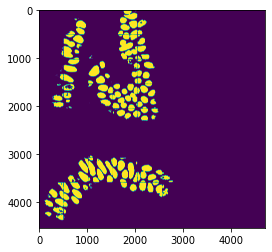

testing HandE_B005_CL_b_RGB_bottomleft


Shaped series: axes do not match shape


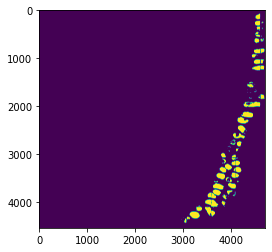

dice scores [0.8751588501232356, 0.7151214544866026]
Average dice score is  0.7951401523049191


In [ ]:
prediction(model_List,test_data_path,df_test,"submission.csv")

testing CL_HandE_1234_B004_bottomright


Shaped series: axes do not match shape


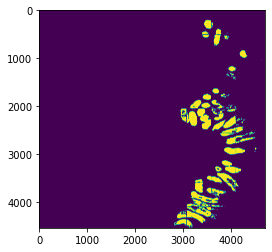

Shaped series: axes do not match shape


testing CL_HandE_1234_B004_topleft


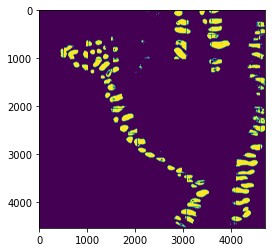

testing CL_HandE_1234_B004_topright


Shaped series: axes do not match shape


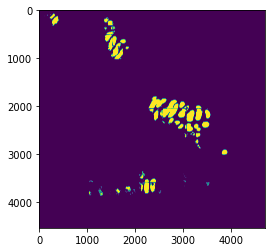

testing HandE_B005_CL_b_RGB_bottomright


Shaped series: axes do not match shape


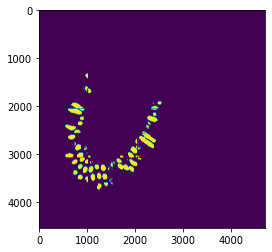

testing HandE_B005_CL_b_RGB_topleft


Shaped series: axes do not match shape


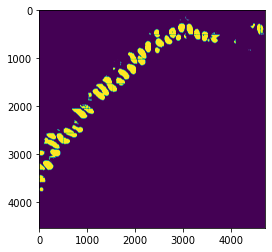

dice scores [0.7902297684303141, 0.8143473842064496, 0.8089536289263017, 0.8302962795308487, 0.8790617750363643]
Average dice score is  0.8245777672260557


In [ ]:
df_train = pd.read_csv("train.csv").iloc[0:-1,:]
train_data_path = "train"
prediction(model_List,train_data_path,df_train,False,"train_predictions.csv")